In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sl
import time

import seaborn as sns; sns.set()
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline



# Tarea 5 y 6: Ecuación de difusión en 3 dimensiones

Uds se preguntarán, ¿por qué vamos a resolver la ecuación de difusión? La respuesta no es muy obvia, pero es interesante: Los procesos de difusión comparten algo muy bonito con los procesos estocásticos. Para ello, vamos a analizar un problema de COVID: el tiempo medio estimado de infección de los viriones.

La transmisión de COVID se da preponderamente debido a la aspersión de aerosoles en el aire. Estas partículas *semi*-esféricas -cuyo orden de magnitud es de $\sim1-10\,\mu m$ de radio- están compuestas principalmente por agua, lípidos orgánicos y viriones (se pueden considerar *quasi*-puntuales ya que son del orden de los $\sim100\,nm$). Cuando una particula del aerosol entra y se adhiere al tracto respiratorio, el virus toma un tiempo en entrar en contacto con las células para infectar el huésped debido al movimiento Browniano. Los viriones, a diferencia de las bacterias, no cuentan con cilios, flagelos u otros mecanismos para desplazarse en los medios, por lo cual, su única esperanza es que por fluctuaciones térmicas puedan llegar a la superficie de la gota de aerosol para replicar su ADN al entrar en contacto con los tejidos susceptibles. Este proceso es en esencia estocástico y se puede modelar mediante la ecuación de Difusión. Esta ecuación tiene dos partes. La idea es que uds resuelvan el problema de la manera más sencilla. La ecuación es la siguiente,
$$
\frac{\partial\Psi}{\partial t}=D\nabla^2\Psi,
$$
donde $D$ es la constante de difusión del medio y $\Psi$ es la concentración de partículas. La taza de difusión depende de la temperatura y la viscosidad del medio y se puede modelar usando la relación de Einstein-Stokes,
$$
D=\frac{k_BT}{6\pi\eta a},
$$
siendo $k_B$ la constante de Boltzmann, $T$ la temperatura en grados Kelvin, $\eta$ la viscosidad del medio y $a$ el radio de los viriones. En esencia, lo que la ecuación de difusión me está diciendo es que la concentración media de viriones depende de la posición y el tiempo. No obstante, para poder calcular el tiempo que tardaría un virión en alcanzar la superficie se puede modelar en la media usando la siguiente ecuación de difusión,
$$
-\nabla^2\tau=\frac{1}{D},
$$
donde $\tau$ es el tiempo medio que dependería de la posición en la que se encuentra inicialmente.

## 1. Escriba la ecuación de difusión para el tiempo $\tau$ en coordenadas esféricas y asuma que $\tau(r,\theta,\phi)\simeq\tau(r)$ ya que por simetría esférica sólo dependerá de la posición radial respecto al centro de la gotica (Usar **LaTex**)

<img src="img007.jpg">

[**Ecuación**]
$$
\ddot{\tau }+\frac{2}{r} \dot{\tau } +\frac{1}{D} = 0
$$



## 2. Resuelva la ecuación diferencial para el tiempo de forma numérica y grafique

Asuma las siguientes condiciones iniciales:
1. $\tau(R)=0$ ya que si el virión está en la superficie el tiempo debe ser naturalmente nulo.
1. $\tau^\prime(r)=0$ ya que por simetría la derivada radial debe ser nula en el origen

Suponga las siguientes condiciones:
- $R=5\mu m$ para el radio de la esfera de *quasi* agua (calcula el volumen $V$)
- $\eta_{\text{H}_2\text{O}}\simeq1\times10^{-3}\,Pa\cdot s$ (Pascales por segundo)
- $\frac{\eta}{\eta_{\text{H}_2\text{O}}}\approx10^3\to10^5$
- $a\simeq100\,nm$
- $V=\frac{4}{3}\pi a^3$
- $k_BT\simeq4.05\times10^{-21}J$

<img src="img008.jpg">
<img src="img009.jpg">
<img src="img010.jpg">
<img src="img011.jpg">


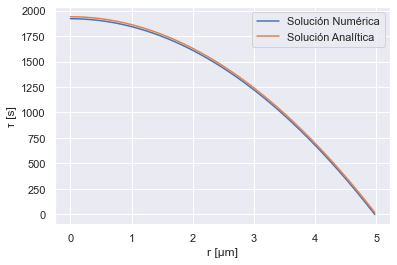

In [2]:
EtaH2O = 10**(3)
Eta_div_EtaH2O = 10**(-3)
Eta = EtaH2O*Eta_div_EtaH2O
D = ( (4.05*10**(-21)) / (6*np.pi*Eta*(100*10**(-9))) )
R = 5*10**(-6)
N = 200
dr = R/N

Tau0 = 0
TauN = 0
r = np.arange(0,R,dr)



M = np.matrix([np.array([(r[i]-dr if j == i-1 and i>0 else 0) for j in range(N)]) for i in range(N)])
M = M + np.matrix([np.array([(-2*r[i] if j == i else 0) for j in range(N)]) for i in range(N)])
M = M + np.matrix([np.array([(r[i]+dr if j == i+1 and i<N-1 else 0) for j in range(N)]) for i in range(N)])


M[0,:] = np.zeros(N)
M[0,0] = 1
M[0,1] = -1
M[-1,:] = np.zeros(N)
M[-1,-1] = 1


C = (-r*(dr**2)/D)
C[0] = Tau0
C[-1] = TauN
C = np.matrix(C).T

Tau = np.array((np.linalg.inv(M)*C).T).flatten()

r_ = np.arange(0,5,5/N) # cambio de escala

plt.plot(r_,Tau, label='Solución Numérica')
plt.plot(r_, (R**2/(6*D))-(1/(6*D)*r**2), label='Solución Analítica')
plt.legend()
plt.xlabel('r [μm]')
plt.ylabel('τ [s]')
plt.show()



## 3. Si los viriones están distribuidos uniformemente, encuentre el tiempo que tardaría un virión en salir de la gota de aerosol.

Tenga presente que debe promediar suponiendo que el virión tiene una distribución uniforme, i.e. $\rho\left(\vec{r}\right)=1/V$, usando la siguiente relación,
$$
\bar{\tau} = \int_{\mathcal{V}}\tau\left(\vec{r}\right)\rho\left(\vec{r}\right)\,\text{d}\vec{r} = \frac{4\pi}{V}\int_{0}^{R}\tau(r)\,r^2\text{d}r.
$$
Realice la integral numéricamente.

In [3]:
#Simpson

V = (4/3)*np.pi*(5*10**(-6))**3  #El volumen, es el volumen de la gota de agua y no del virus
R = 5*10**(-6)
r_ini =0.000001
r_fin =R
nodos=1000001


def T(r):
    return ((4*np.pi)/V)*((R**2/(6*D))-(1/(6*D)*r**2))*(r**2)



def simpson_integrate(desde, hasta, nodos, T):
    x, delta_x = np.linspace( desde, hasta, num=nodos-1 , retstep=True  )
    return (delta_x/3)*(   T(x[0]) + 2*np.sum(T(x[2:len(x)-1:2])) + 4*np.sum(T(x[1::2])) + T(x[-1]) )



    
integral_T = simpson_integrate(r_ini, r_fin, nodos, T)    




print(f"Por función propia: τ promedio es {round(integral_T, 2)} s")
print(f"Por función de scypi: τ promedio es {round(sp.integrate.simpson(Tau*r**2*4*np.pi/V, r), 2)} s")
print()
print('Observar que depende de los valores de Eta despejados (sea 0 ó 10^2) respectivamente, donde el tiempo promedio puede variar entre 12 min. o 21 horas.')


Por función propia: τ promedio es 760.56 s
Por función de scypi: τ promedio es 756.5 s

Observar que depende de los valores de Eta despejados (sea 0 ó 10^2) respectivamente, donde el tiempo promedio puede variar entre 12 min. o 21 horas.


## 4. Las cadenas de Markov.

Vamos a resolver el problema anterior usando un proceso de Markov. Suponga que ud **divide** la esfera en cubitos de ancho $\delta x=\delta y=\delta z=\Delta=R/N$ con $N$ un número determinado de particiones. Para nuestro experimento, vamos a suponer que ponemos un virión en una posición inicial $\vec{r}_0=(\Delta\,j, 0, 0)$, determinada por un índice $j\in\{0,1,2,\dots,N\}$. Ud va a actualizar la posición del virión en la malla discreta siguiendo las reglas a continuación:
- Determine el número de divisiones $N$ y calcule $\Delta$.
- Ajuste la escala de tiempo $\delta t$ y de tal manera que la probabilidad $\alpha=D\frac{\delta t}{\Delta^2}<\frac{1}{6}$. (Recomiendo $\leq1/12$)
- Haga una corrida de Markov-Monte Carlo actualizando la posición con la probabilidad de transición $\alpha$ hacia los primeros vecinos cercanos y calcule el número de pasos de tiempo para llegar a la superficie, i.e. $|\vec{r}(t_m)|>R-\Delta$
- Repita este experimento para la misma posición un gran número de veces para obtener una estadística (media y desviación estándar).
- Repita todos los pasos para todos los índices $j\in\{0,1,2,\dots,N\}$ y grafique. ¡Compare con los resultados anteriores!

In [4]:
R = 5*10**(-6)
N = 2000            #Determionación de N
delta = R/N        #Cálculo de delta
dt = N*(1*10**(-5))    # dt ajustado a condiciones <= 1/12
interval = np.arange(0,R,delta)
psi = np.zeros(N+1)


alpha = D*(N*(1*10**(-5))/(delta**2)) #Probabilidad




def actualiza_objetos(n):
    global psi
    # esta funcion me dice de n objetos cuantos van a la izquierda y cuantos a la derecha
    v = np.random.uniform(size=n)
    izq = sum(v<alpha)
    der = sum(v<alpha/n) - izq
    return (izq,der)

def actualiza_psi(psi):
    # calcular cuantos se van a la derecha y cuantos a la izquierda
    dpsi = np.array([actualiza_objetos(_psi) for _psi in psi]).T                     #Esta parte falla en el codigo y no se como hacer funcionar
    # verificar cuantos hay.... reajustar cuantos se van: condiciones de frontera
    dpsi[0,0] = 0
    dpsi[1,-1] = 0
    # sumar los q tenia psi0 + los q llegan - los q se van
    dpsi_izq = np.roll(dpsi[0],-1)
    dpsi_der = np.roll(dpsi[1], 1)
    dpsi = np.sum(dpsi, axis=0)
    return psi-dpsi+dpsi_izq+dpsi_der



# condiciones iniciales
psi[0] = 0
psi[N//2] = 0
plt.hist(psi)
"""

print(len(interval))
print(len(psi))
"""

def cambio(psi, probabilidad, R):
    contador = 0
    while(contador <= probabilidad):
        psi = actualiza_psi(psi)
        contador = contador + 1
    return([psi, contador])


#Grafica________________________________________________________________________

res = cambio(psi, alpha, R)
plt.hist(res[0])
plt.show()
Print('Pasos hasta que el virus sale de la superficie de la gota y entra en contacto con el huesped: ', res[1])


#Repeticion de veces:___________________________________________________________________________-

veces = 500000
distancia_rec = []
pasos = []
for i in range(veces):
    pasos.append(cambio(psi, alpha, R)[1])
    distancia_rec.append(R-(cambio(psi, alpha, R)[0][0])

                         
                         
                         
                         
print('Promeio de la cantidad de pasos que hace el virus antes de infectar al huesped: ', np.mean(pasos))
print('La desviacion estandar de la cantidad de pasos que hace el virus antes de infectar al huesped: ', np.std(pasos))
print()                         
print('Promedio de la distancia que recorre el virus antes de infectar al huesped: ', np.mean(distancia_rec))
print('La desviacion estandar de la distancia que recorre el virus antes de infectar al huesped: ', np.std(distancia_rec))
                         

    



SyntaxError: invalid syntax (<ipython-input-4-59c8e2422913>, line 75)

In [118]:
n = 9
v = np.random.uniform(size=n)
izq = sum(v<alpha)
der = sum(v<alpha/9)-izq


print(alpha)
print(v)
print(izq, der)
print(v<alpha)
print(v<alpha/9)
print(2*alpha)


6.875493541569879
[0.06331866 0.43066997 0.91771926 0.71327559 0.3237243  0.69576129
 0.59992304 0.92493171 0.07641644]
9 -2
[ True  True  True  True  True  True  True  True  True]
[ True  True False  True  True  True  True False  True]
13.750987083139758


In [124]:
actualiza_objetos(_psi) for _psi in psi

SyntaxError: invalid syntax (<ipython-input-124-4d4113aa42f2>, line 1)